# CL Fall School 2024 in Passau: Multimodal NLP
Carina Silberer, University of Stuttgart

---

# Lab 2: Image--Text similarity (matching) and zero-shot classification wih CLIP
*This notebook is an adaptation of for CLIP ([openai's github/colab material](https://github.com/openai/CLIP/tree/main/notebooks)) and the colab material from the Stanford 2022 course cs231n by Fei-Fei Li (github material).*


## CLIP
Documentation and code of CLIP: https://github.com/openai/CLIP

In this notebook, you will be working with CLIP (Contrastive Language-Image Pre-Training) model. We will be using the implementation and the pre-trained model based on [VIT](https://huggingface.co/docs/transformers/model_doc/vit#overview) (see the course slides of the second day).

### Setup
*Install transformers if you don't have them yet.*

In [50]:
!pip install -q git+https://github.com/huggingface/transformers.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


*If torch is not installed yet, check how to install it on your device: (https://pytorch.org/get-started/locally)*
For example, you may use <br/>
`!pip3 install torch torchvision torchaudio` <br/>
or <br/>
`!conda install pytorch torchvision -c pytorch`

In [51]:
#conda update -n base -c defaults conda

In [54]:
# python built-in packages
import os 
import sys
from collections import OrderedDict

# We need additional packages for loading (and visualising) the images
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    import skimage
except ModuleNotFoundError:
    !conda install --yes scikit-image 
    import skimage
    
# libraries we'll need for image loading, numerical operations, deep learning models and data analysis 
from PIL import Image # to load images
import numpy as np
import torch
print("Torch version:", torch.__version__)

Torch version: 2.6.0.dev20240914


In [32]:
try:
    import pandas # for data analysis and manipulation
except ModuleNotFoundError:
    !conda install pandas
    #!pip install pandas
    import pandas

In [ ]:
# load torchvision
from pkg_resources import packaging
import torchvision
print("Torch vision version: ", torchvision.__version__)
#import torch
#torch.__version__

In [ ]:
#! pip install datasets==2.21.0 # install datasets from huggingface
from datasets import load_dataset

### Warm-Up: Setting up the data and interacting with CLIP

We first need to download the CLIP models and set up some data of image and text. 
Then we will run CLIP to 
* calculate the similarity between arbitrary image and text inputs and 
* perform zero-shot image classifications.

In [64]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", clean_up_tokenization_spaces=True)

#### Data: Setting up input images and texts

We are going to feed some example images and their textual descriptions of the [Color Dataset (CoDa)](https://huggingface.co/datasets/corypaik/coda) to the model, and compare the similarity between the corresponding features. CoDa is a  dataset to evaluate language models in terms of their representation of visual properties.  

The tokeniser is case-insensitive, and we can feed it any suitable textual description.

Set your directory paths according to your local setup. The code below assumes that the image folder is stored under data/:

In [35]:
# TODO: set up your paths.
FOLDERNAME = "data"
image_dir = '{}/coloured_objects/'.format(FOLDERNAME)
data_dir = '{}/coloured_objects/'.format(FOLDERNAME)

*Now, we create some examples of `coloured_objects`*

In [36]:
# example images in coda (retrieved from multiPIC, inter alia) and some descriptions for them written by yourselves
descriptions = [
    ("PICTURE_69.png", "A grey-scale photo of a fruit ."),
    ("PICTURE_693.png", "A grey-scale photo of a tree ."),
    ("PICTURE_697.png", "This shows an fruit ."),
    ("PICTURE_707.png", "A grey-scale photo of a dog ."),
    ("banana_wikipedia.jpg", "This is a photo of a banana ."),
    ("PICTURE_42.png", "A photo of a pear ."),
    ("banana_gratismalvorlagen.png", "A photo of a banana ."),
    ("peach_supercoloring.png", "A grey-scale photo of a peach ."),
    # from the SWiG dataset (Pratt et al., 2019)
    ("peeling_91.jpg", "The banana is being peeled .")   
]

In [37]:
for filename in [filename for filename in os.listdir(data_dir)]:
    print(filename)

banana_wikipedia.jpg
PICTURE_693.png
PICTURE_697.png
PICTURE_42.png
PICTURE_69.png
peach_supercoloring.png
peeling_91.jpg
banana_gratismalvorlagen.png
PICTURE_707.png


***Let's visualise the image--text pairs:***

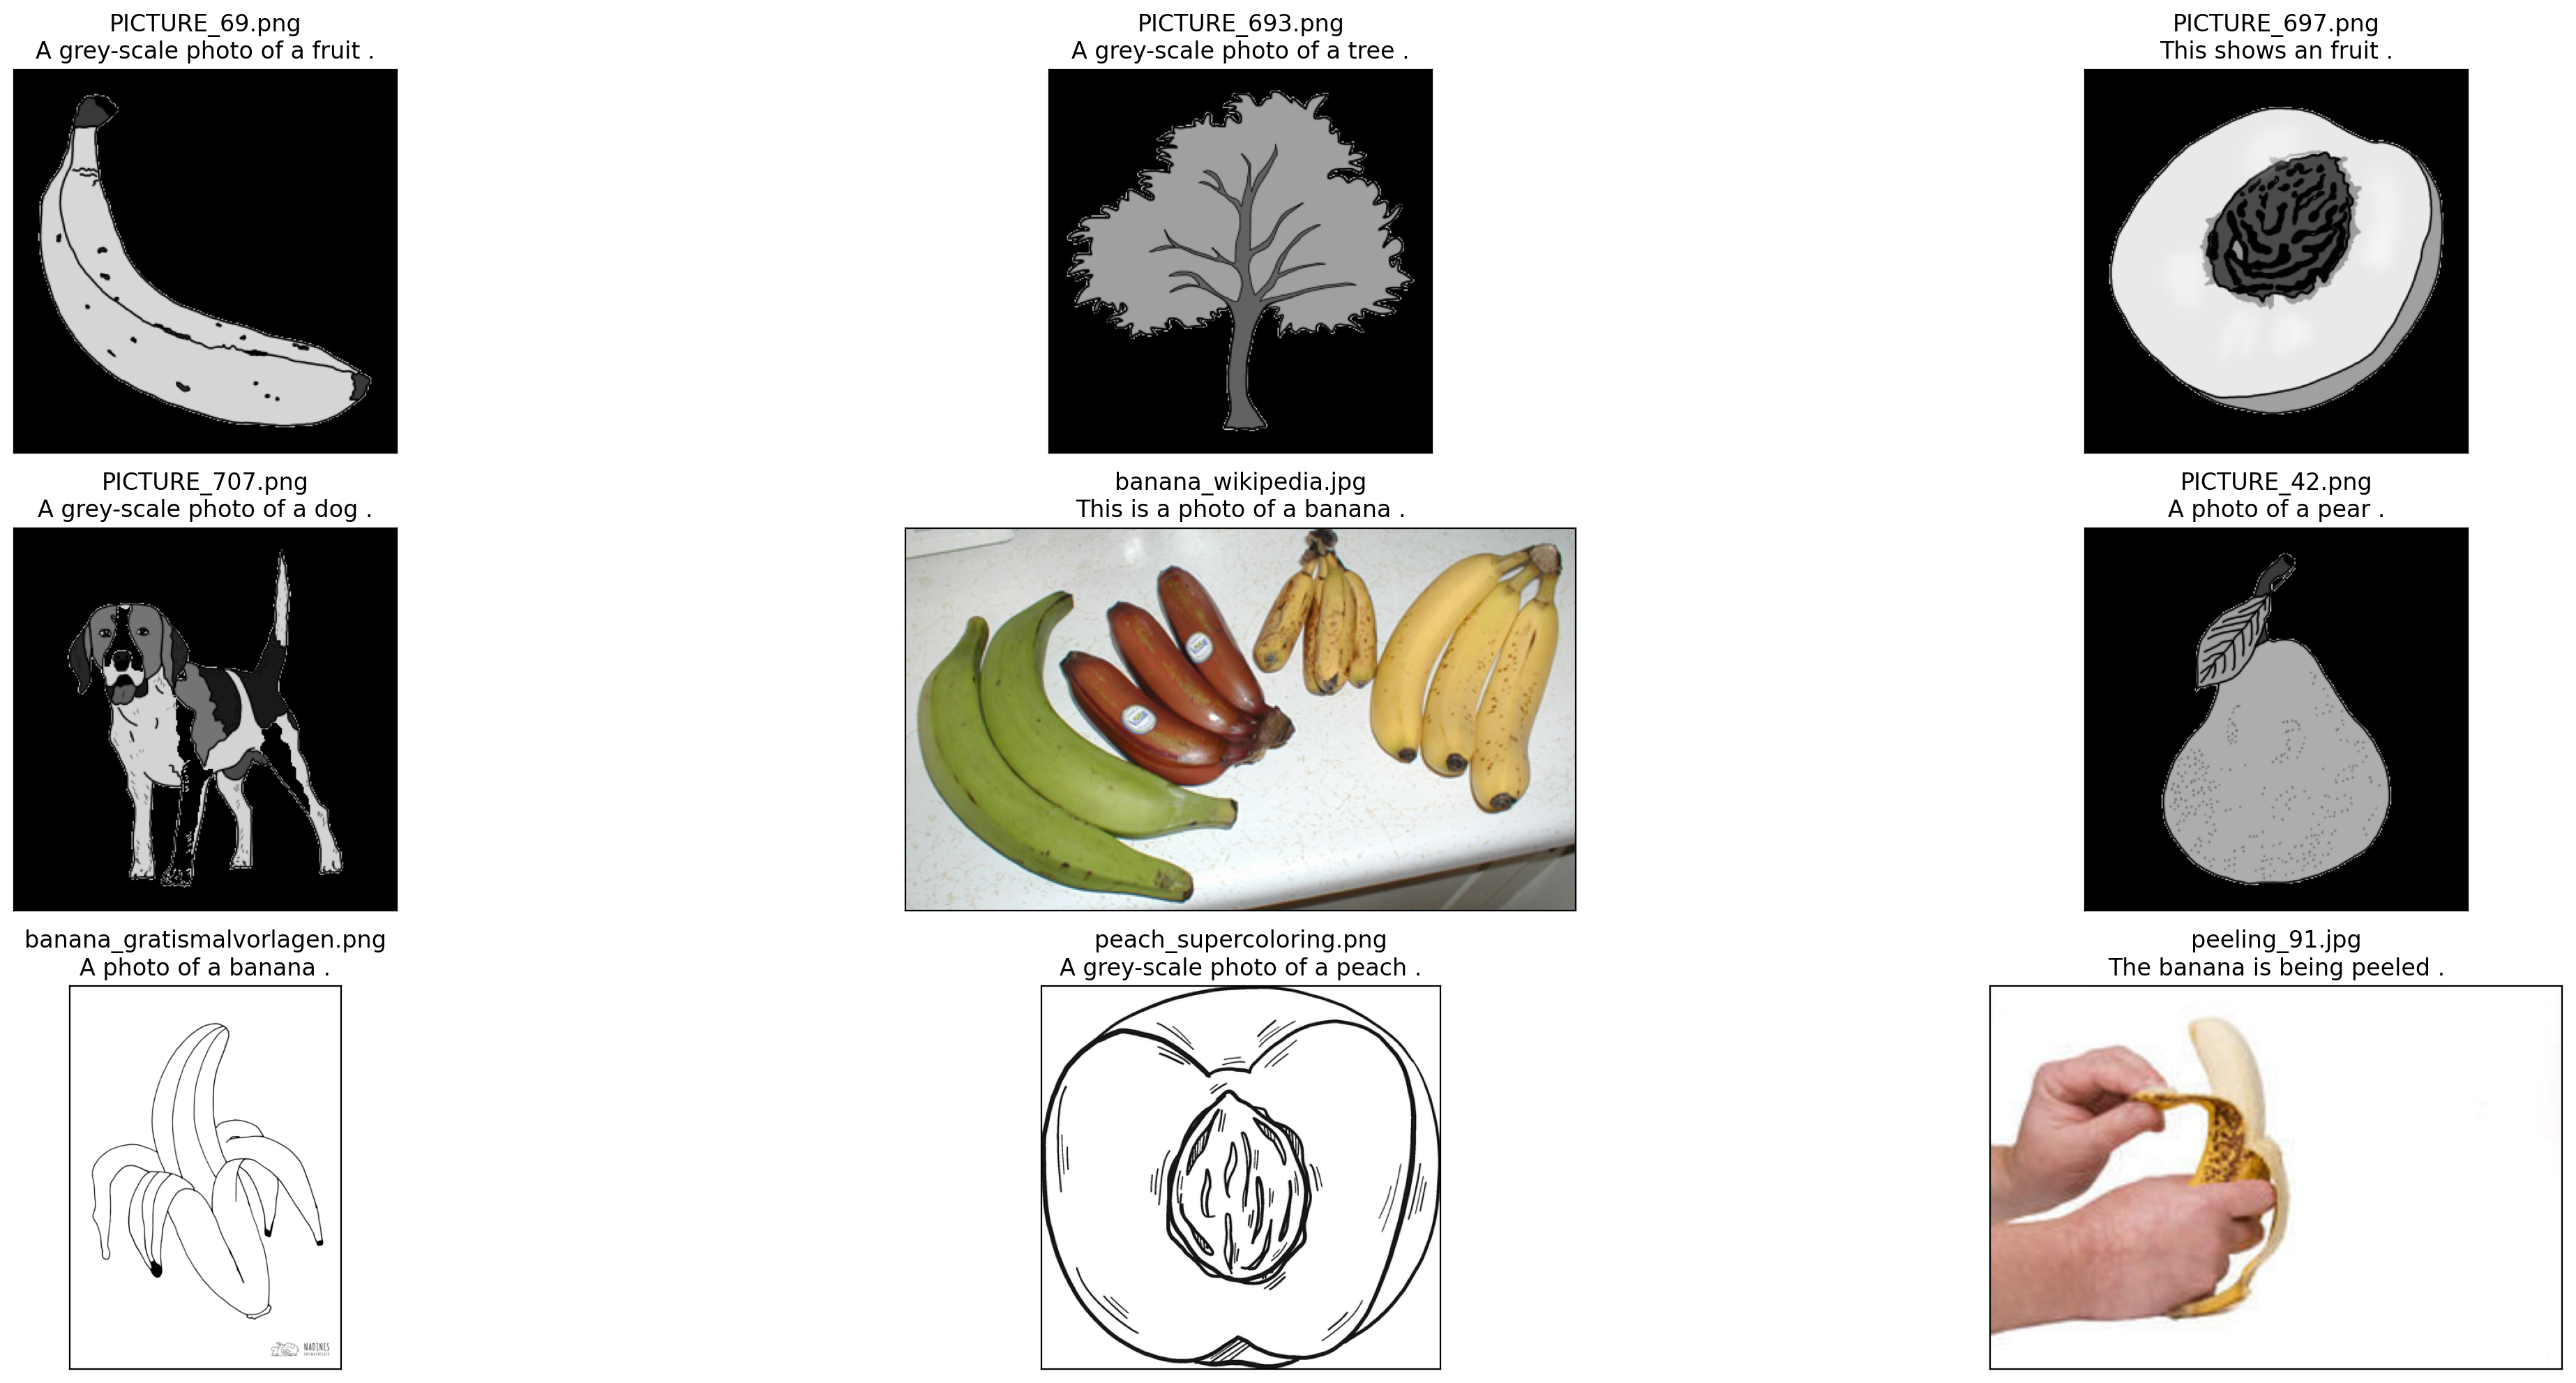

In [56]:
# plot the image-text pairs
plt.figure(figsize=(25, 10))

num_imgs = 0
for (item_id, descr) in descriptions:
    if item_id.endswith(".png") or item_id.endswith(".jpg"):
        filename = item_id
        name = os.path.splitext(filename)[0]
        image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
        plt.subplot(3, 3, num_imgs + 1)
        plt.imshow(image)
        plt.title(f"{filename}\n{descr}")
        plt.xticks([])
        plt.yticks([])

        num_imgs += 1

plt.tight_layout()

***We can load the data into some simple data structures (`list`), and then use a function for plotting them:***

In [78]:
# Load data:
images = []
texts = []
imgnames = []

for (item_id, descr) in descriptions:
    if item_id.endswith(".png") or item_id.endswith(".jpg"):
        filename = item_id
        name = os.path.splitext(filename)[0]
        image = Image.open(os.path.join(image_dir, filename)).convert("RGB") # open the filename and convert it to an image
        images.append(image) # add the image to a list
        texts.append(descr) # add the description to a list
        imgnames.append(item_id)

In [63]:
# texts now is a list containing the descriptions
texts

['A grey-scale photo of a fruit .',
 'A grey-scale photo of a tree .',
 'This shows an fruit .',
 'A grey-scale photo of a dog .',
 'This is a photo of a banana .',
 'A photo of a pear .',
 'A photo of a banana .',
 'A grey-scale photo of a peach .',
 'The banana is being peeled .']

In [59]:
# Visualisation by iterating over the lists of images and texts
# images or original_images
def visualise(imgnm_list, img_list, text_list):
    plt.figure(figsize=(25, 10))
    num_imgs = 0
    for (item_id, image, descr) in zip(imgnm_list, img_list, text_list):
        if item_id.endswith(".png") or item_id.endswith(".jpg"):
            plt.subplot(3, 3, num_imgs + 1)
            plt.imshow(image)
            plt.title(f"{item_id}\n{descr}")
            plt.xticks([])
            plt.yticks([])

            num_imgs += 1

    plt.tight_layout()

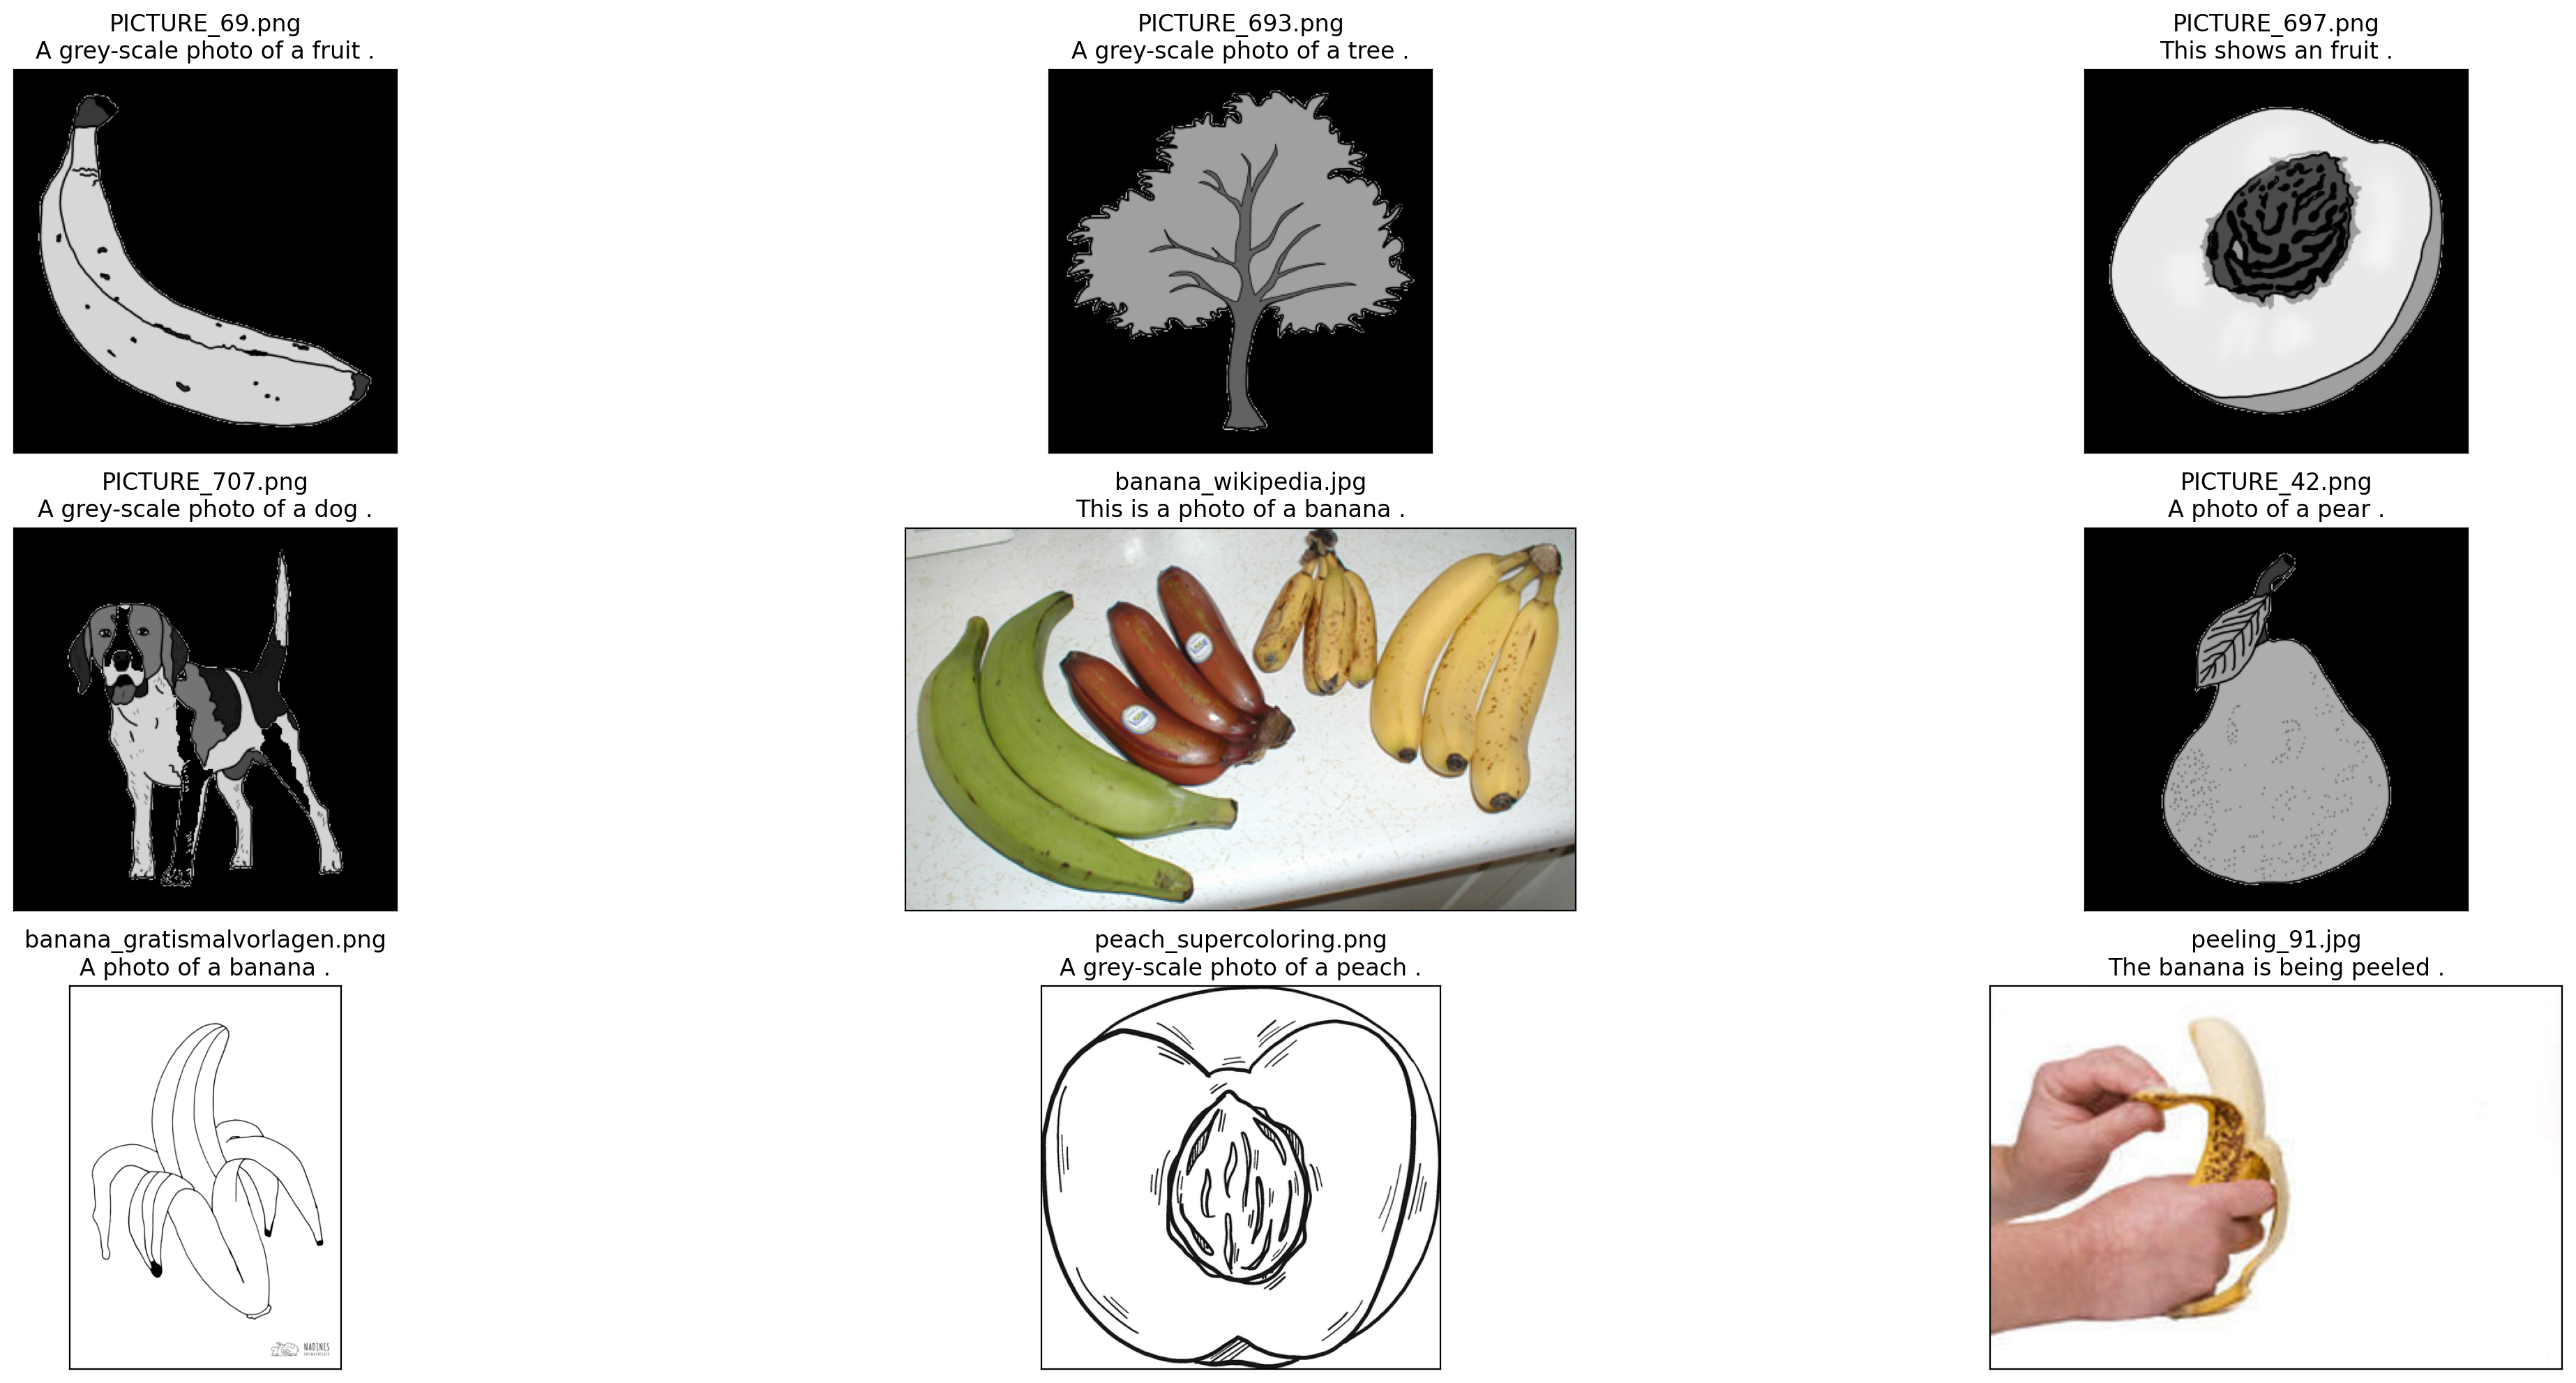

In [60]:
# imgnames, images texts
visualise(imgnames, images, texts)

#### Interacting with CLIP: Similarity
Now let's compute cosine similarities between all image and text pairs: We get features for the images and texts using the `processor`, and then and calculate the dot product of each pair, i.e., compute the cosine similarity between each image--text pair. It gives a score between -1 (or 0) and 1, with 1 meaning that the image and the text are identical.

In [66]:
with torch.no_grad():
    # the CLIP processor maps the input texts and images to features representations
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # then we use CLIP to calculate the dot product
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    similarity = logits_per_image.detach().numpy()/100.0
    #probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

Text(0.5, 1.0, 'Cosine similarity between text and image features')

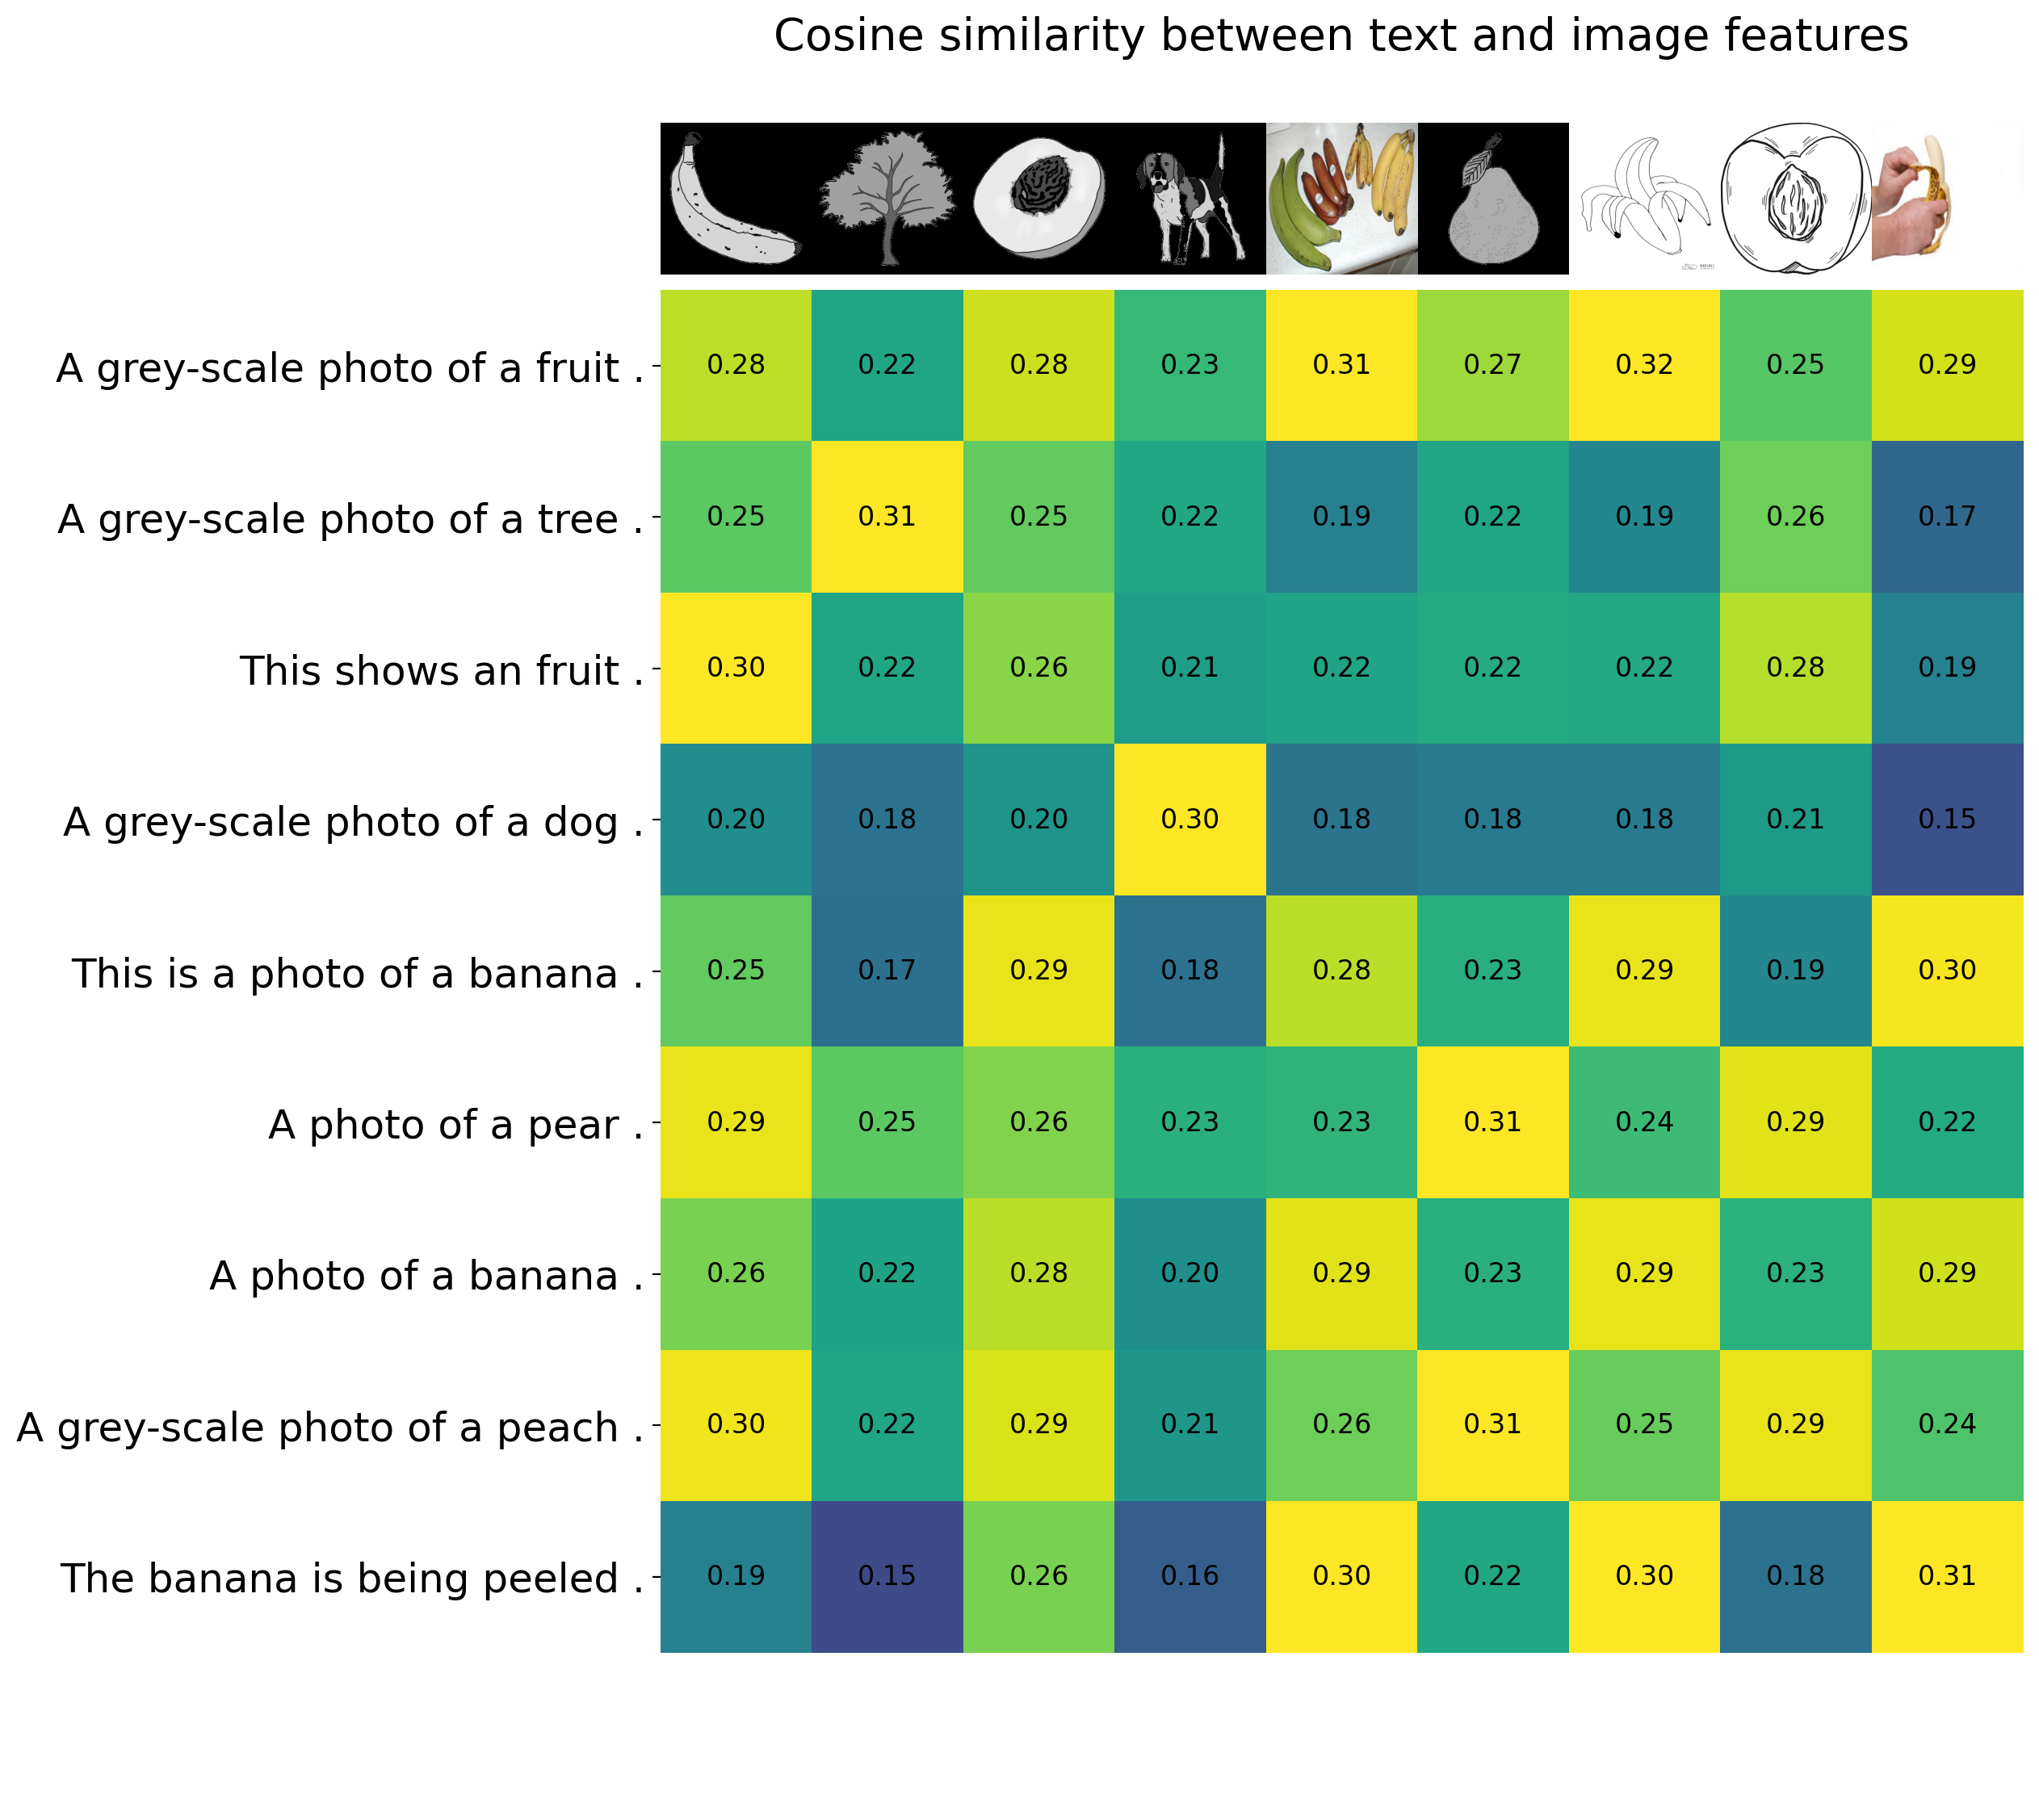

In [68]:
count = len(texts)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

**Exercise:** Inspect the similarity scores between the descriptions and the images, and how the scores are (not) affected  by different verbalisations.



---
### Interim Summary (of Image--Text Matching): Ingredients
1. Set up data, and load it into some simple data structure (see above)
2. Encode the images and texts into feature representations using CLIP
3. Compute the image--text compatibility using cosine similarity
4. (Visualise results)

---

### Exercise 2: Zero-shot classification

You can choose some vocabulary of target classes, and use them to classify your own images. The classification is based on the cosine similarity (times 100), specifically, on the logits to the softmax operation applied to the similarity scores.

#### Getting class labels
You can freely determine your own vocabulary (class labels). For now, we first will use the CIFAR100 class labels. There are two ways to get them (besides handcoding them directly in the form of a list of strings, where each string is a class label):

**1. Either get the CIFAR classes from huggingface:**

If you get an error when trying to import load_dataset, install `datasets`from huggingface, **restart the kernel** and try again.

In [22]:
#! pip install datasets==2.21.0 # install datasets from huggingface
from datasets import load_dataset

ds = load_dataset("uoft-cs/cifar100")
cifar100_classes = ds["train"].features["fine_label"].names

**2. or from torchvision**

In [28]:
from torchvision.datasets import CIFAR100
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), download=True)
cifar100_classes = cifar100.classes

Files already downloaded and verified


In [29]:
cifar100_classes[:10]

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

#### Preparing the text input
CLIP expects phrases, not single words. Therefore, wie will turn the class labels into some "prompts" and use these as textual input. 
For that, we use a template, and instantiate the template with the target classes to obtain the textual prompts:

In [69]:
text_descriptions = [f"this {label} is dancing in the rain with a black shirt ." for label in cifar100_classes]

In [71]:
text_descriptions[:2] # first two prompts

['this apple is dancing in the rain with a black shirt .',
 'this aquarium_fish is dancing in the rain with a black shirt .']

Now we can predict the classes for each test instance using zero-shot classification. This is actually simply calculating the dot product between each text--image pair, and turning the scores into probabilities (denoting the probability of each text, i.e., class):

In [72]:
with torch.no_grad():
    inputs = processor(text=text_descriptions, images=images, return_tensors="pt", padding=True)
    
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    #similarity = logits_per_image.detach().numpy()/100.0
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

Let's just inspect look at the topk=4 predicted class labels per image:

In [73]:
topKlabels = 4
top_probs, top_labels = probs.cpu().topk(topKlabels, dim=-1)

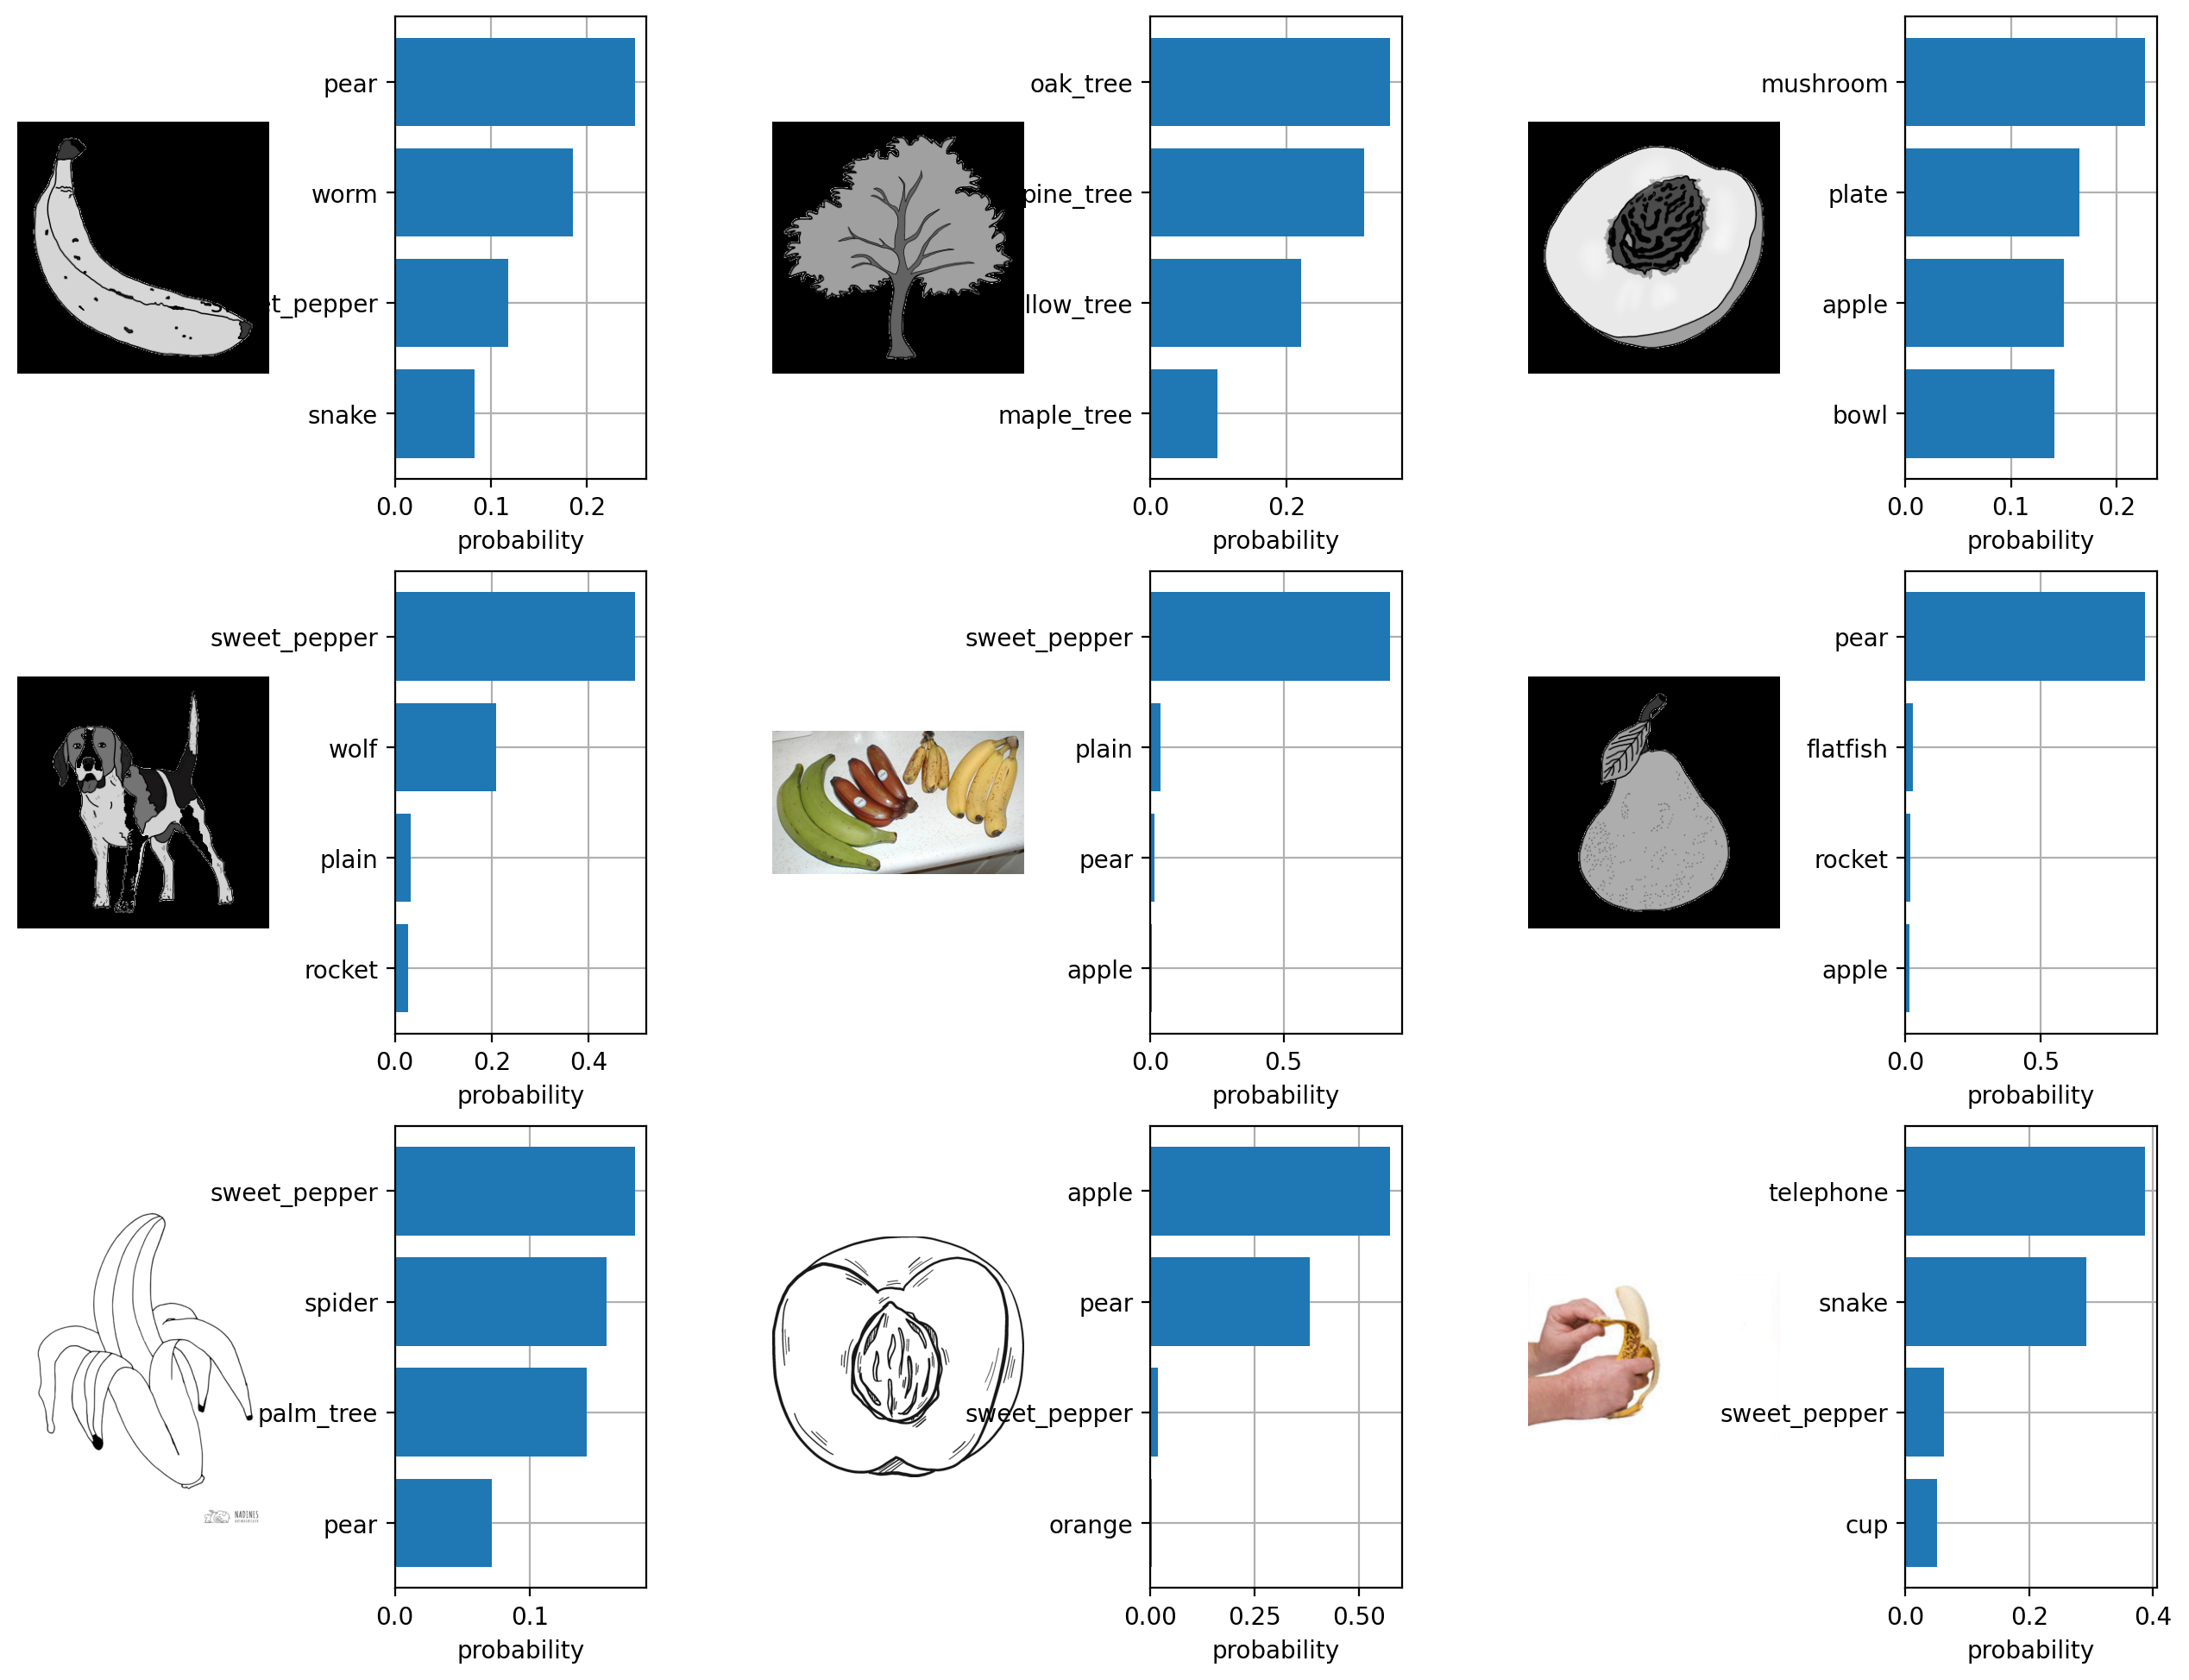

In [74]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(images):
    plt.subplot(4, 6, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 6, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

**Exercise:** Look at the top predicted classes. Do they make sense?

*Let's try another text prompt:*

In [75]:
text_descriptions = [f"this is a photo of a {label}  ." for label in cifar100_classes]

In [ ]:
with torch.no_grad():
    inputs = processor(text=text_descriptions, images=images, return_tensors="pt", padding=True)
    
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

top_probs, top_labels = probs.cpu().topk(4, dim=-1)

In [76]:
# function for plotting
def plot_predictions(images, imagenames, 
                     pred_probs, pred_labels, target_labels):
    plt.figure(figsize=(16, 16))

    for i, image in enumerate(images):
        plt.subplot(4, 6, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.subplot(4, 6, 2 * i + 2)
        y = np.arange(pred_probs.shape[-1])
        plt.grid()

        plt.title(imagenames[i])
        plt.barh(y, pred_probs[i])

        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
      
        plt.yticks(y, [target_labels[index] for index in pred_labels[i].numpy()])
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

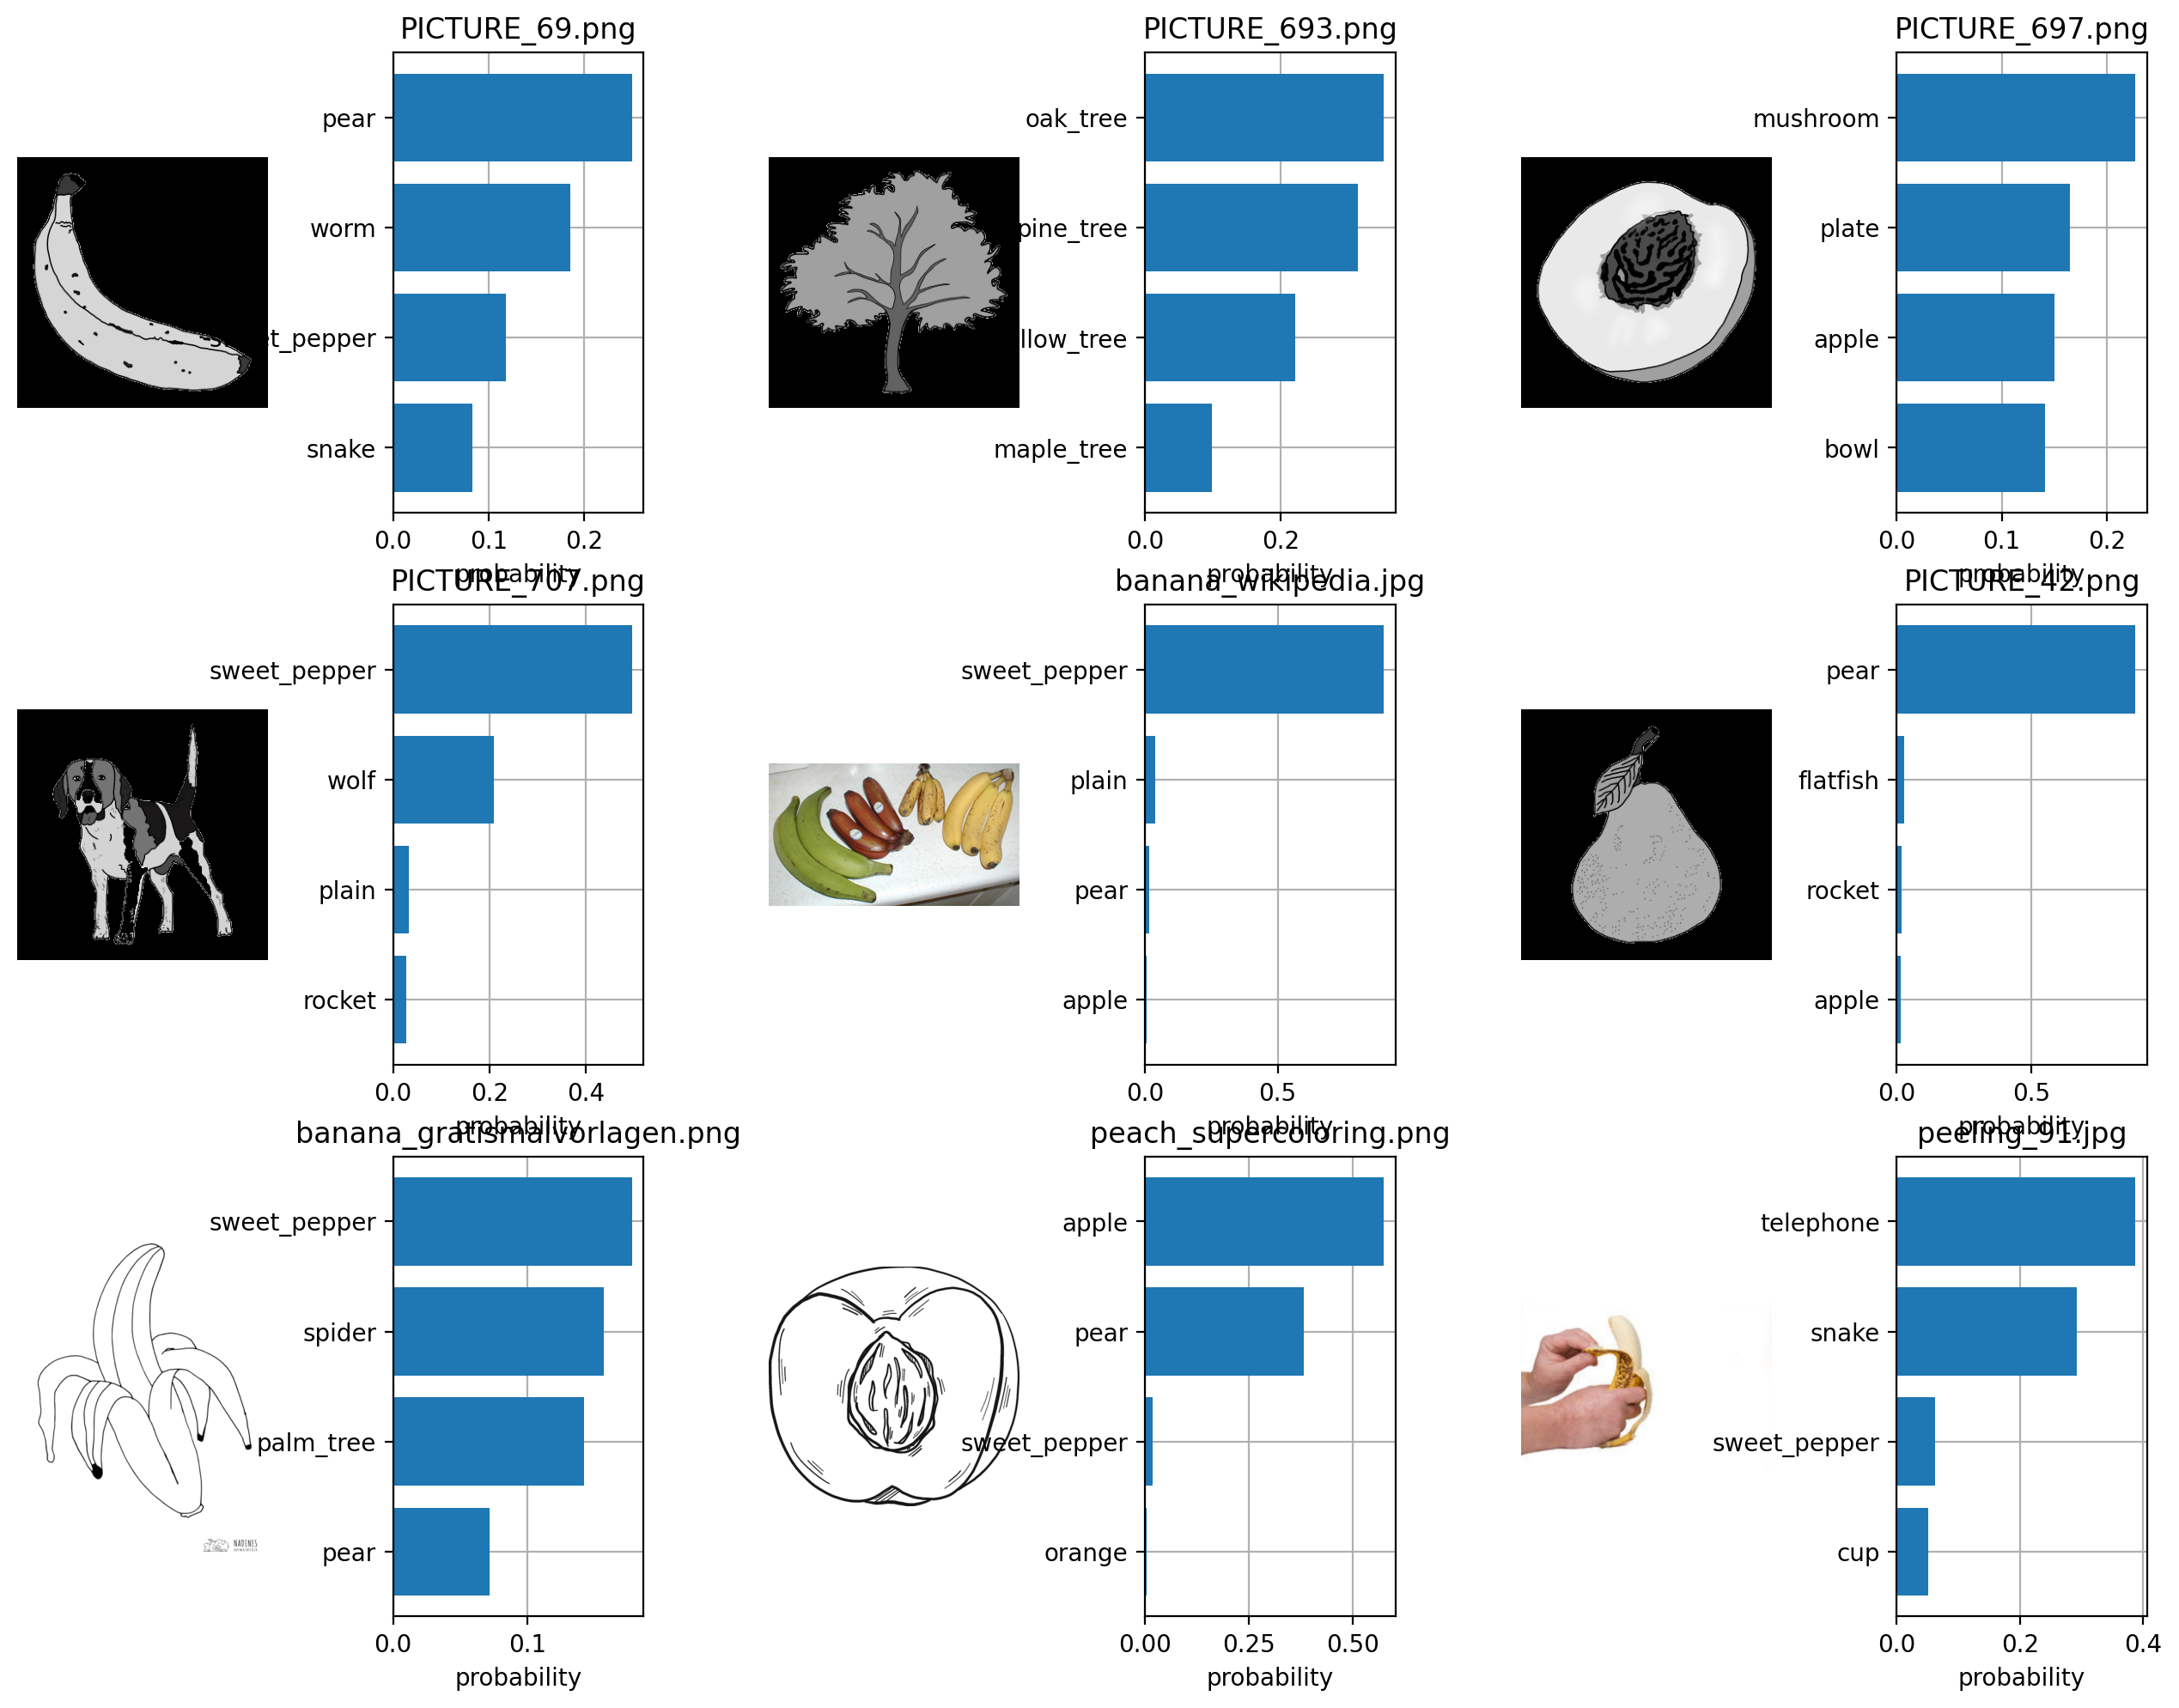

In [79]:
plot_predictions(images, imgnames, top_probs, top_labels, cifar100_classes)

**Exercise:** *Inspect the differences in the predictions depending on the textual prompt. Also note the dependence on the target classes that we gave during inference (100 CIFAR classes).*

### The following code for zero-shot classification is an adaptation of 
https://colab.research.google.com/drive/14m4_zvpW-ZFuXp-KuvNryEKBZoe7NqGA#scrollTo=Mi69N2phL0kU&line=1&uniqifier=1

---
### Interim Summary (Zero-Shot Classification): Ingredients
1. Data setup: (i) get image--class pairs, where the classes are the reference data, and load the data (ii) define a corresponding target vocabulary of classes, (iii) define one or more textual prompts, that you need to instantiate with all target classes.
2. Encode the images and textual prompts into feature representations using CLIP
3. Inference: Predict the class for each input instance, using zero-shot classification
4. (Not shown above:) Compute the accuracy
5. (Visualise results)

**1. Data setup** <br/>
1. (i) Loading the data: see above

In [86]:
# image: label (frame/object class)
coloured_objects_data = {
    # Q: How to adapt to multi-label prediction?
    "PICTURE_69.png": "banana",
    "PICTURE_693.png": "tree",
    "PICTURE_697.png": "peach",
    "PICTURE_707.png": "dog",
    "banana_wikipedia.jpg": "banana",
    "PICTURE_42.png": "pear",
    "banana_gratismalvorlagen.png": "banana",
    "peach_supercoloring.png": "peach",
    "peeling_91.jpg": "peeling"
}

In [87]:
target_classes = ["tree", "cat", "woman", "pizza", 
                    "banana", "pear", "barbecue", "flower", 
                    "puppy", "dog", "peach", 
                    "apple", "eating", "peeling"]
target_class2idx = {c:idx for (idx,c) in enumerate(target_classes)}

In [88]:
# Needed for computing the accuracy (see below):
target_class2idx

{'tree': 0,
 'cat': 1,
 'woman': 2,
 'pizza': 3,
 'banana': 4,
 'pear': 5,
 'barbecue': 6,
 'flower': 7,
 'puppy': 8,
 'dog': 9,
 'peach': 10,
 'apple': 11,
 'eating': 12,
 'peeling': 13}

In [89]:
# For zero-shot classification
# Possible prompts (best would be to use all of them):
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.']

In [92]:
text_descriptions = [f"a rendering of a {label} ." for label in target_classes]

**2. Encoding the textual prompt(s), and the images** <br/>
To encode the textual prompts, you can use the method `zeroshot_classifier` which provides above functionality, additionally using different prompts:

In [93]:
def predict(images, texts, classnames, model, topk=5):
    num_classes = len(classnames)
    with torch.no_grad():
        inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    top_probs, top_labels = probs.cpu().topk(topk, dim=-1)
    return top_probs, top_labels

In [94]:
top_probs, top_labels = predict(images, text_descriptions, target_classes, model)
top_labels

tensor([[ 4,  5, 13, 11, 12],
        [ 0, 13,  7, 10, 11],
        [11, 10,  7, 12,  5],
        [ 9,  8,  1,  2, 13],
        [ 4, 13, 12,  5,  6],
        [ 5, 11, 10,  0, 13],
        [ 4, 13, 12,  5,  7],
        [11,  5, 10,  7, 13],
        [ 4, 13, 12, 11,  5]])

**4. Compute the accuracy**

In [131]:
# Note that the function expects the reference target classes encoded 
# as a vector of class indices (see below)
def accuracy(pred_scores, preds, targets, topk=(1,5)):
    correct = top_labels.eq(targets.view(targets.size(0), -1).expand_as(top_labels))
    acc1, acc5 = [correct[:,:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()[0]/top_probs.shape[0] for k in topk]
    return acc1, acc5

In [96]:
coloured_objects_data

{'PICTURE_69.png': 'banana',
 'PICTURE_693.png': 'tree',
 'PICTURE_697.png': 'peach',
 'PICTURE_707.png': 'dog',
 'banana_wikipedia.jpg': 'banana',
 'PICTURE_42.png': 'pear',
 'banana_gratismalvorlagen.png': 'banana',
 'peach_supercoloring.png': 'peach',
 'peeling_91.jpg': 'peeling'}

In [126]:
# Example:
# First put the targets in the reference data into 
# a vector of target class indices
list_target_inds = [target_class2idx[coloured_objects_data[imgname]] for imgname in imgnames]
target_inds = torch.tensor(list_target_inds).cpu()
    
accuracy(top_probs, top_labels, target_inds, topk=(1,5))

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

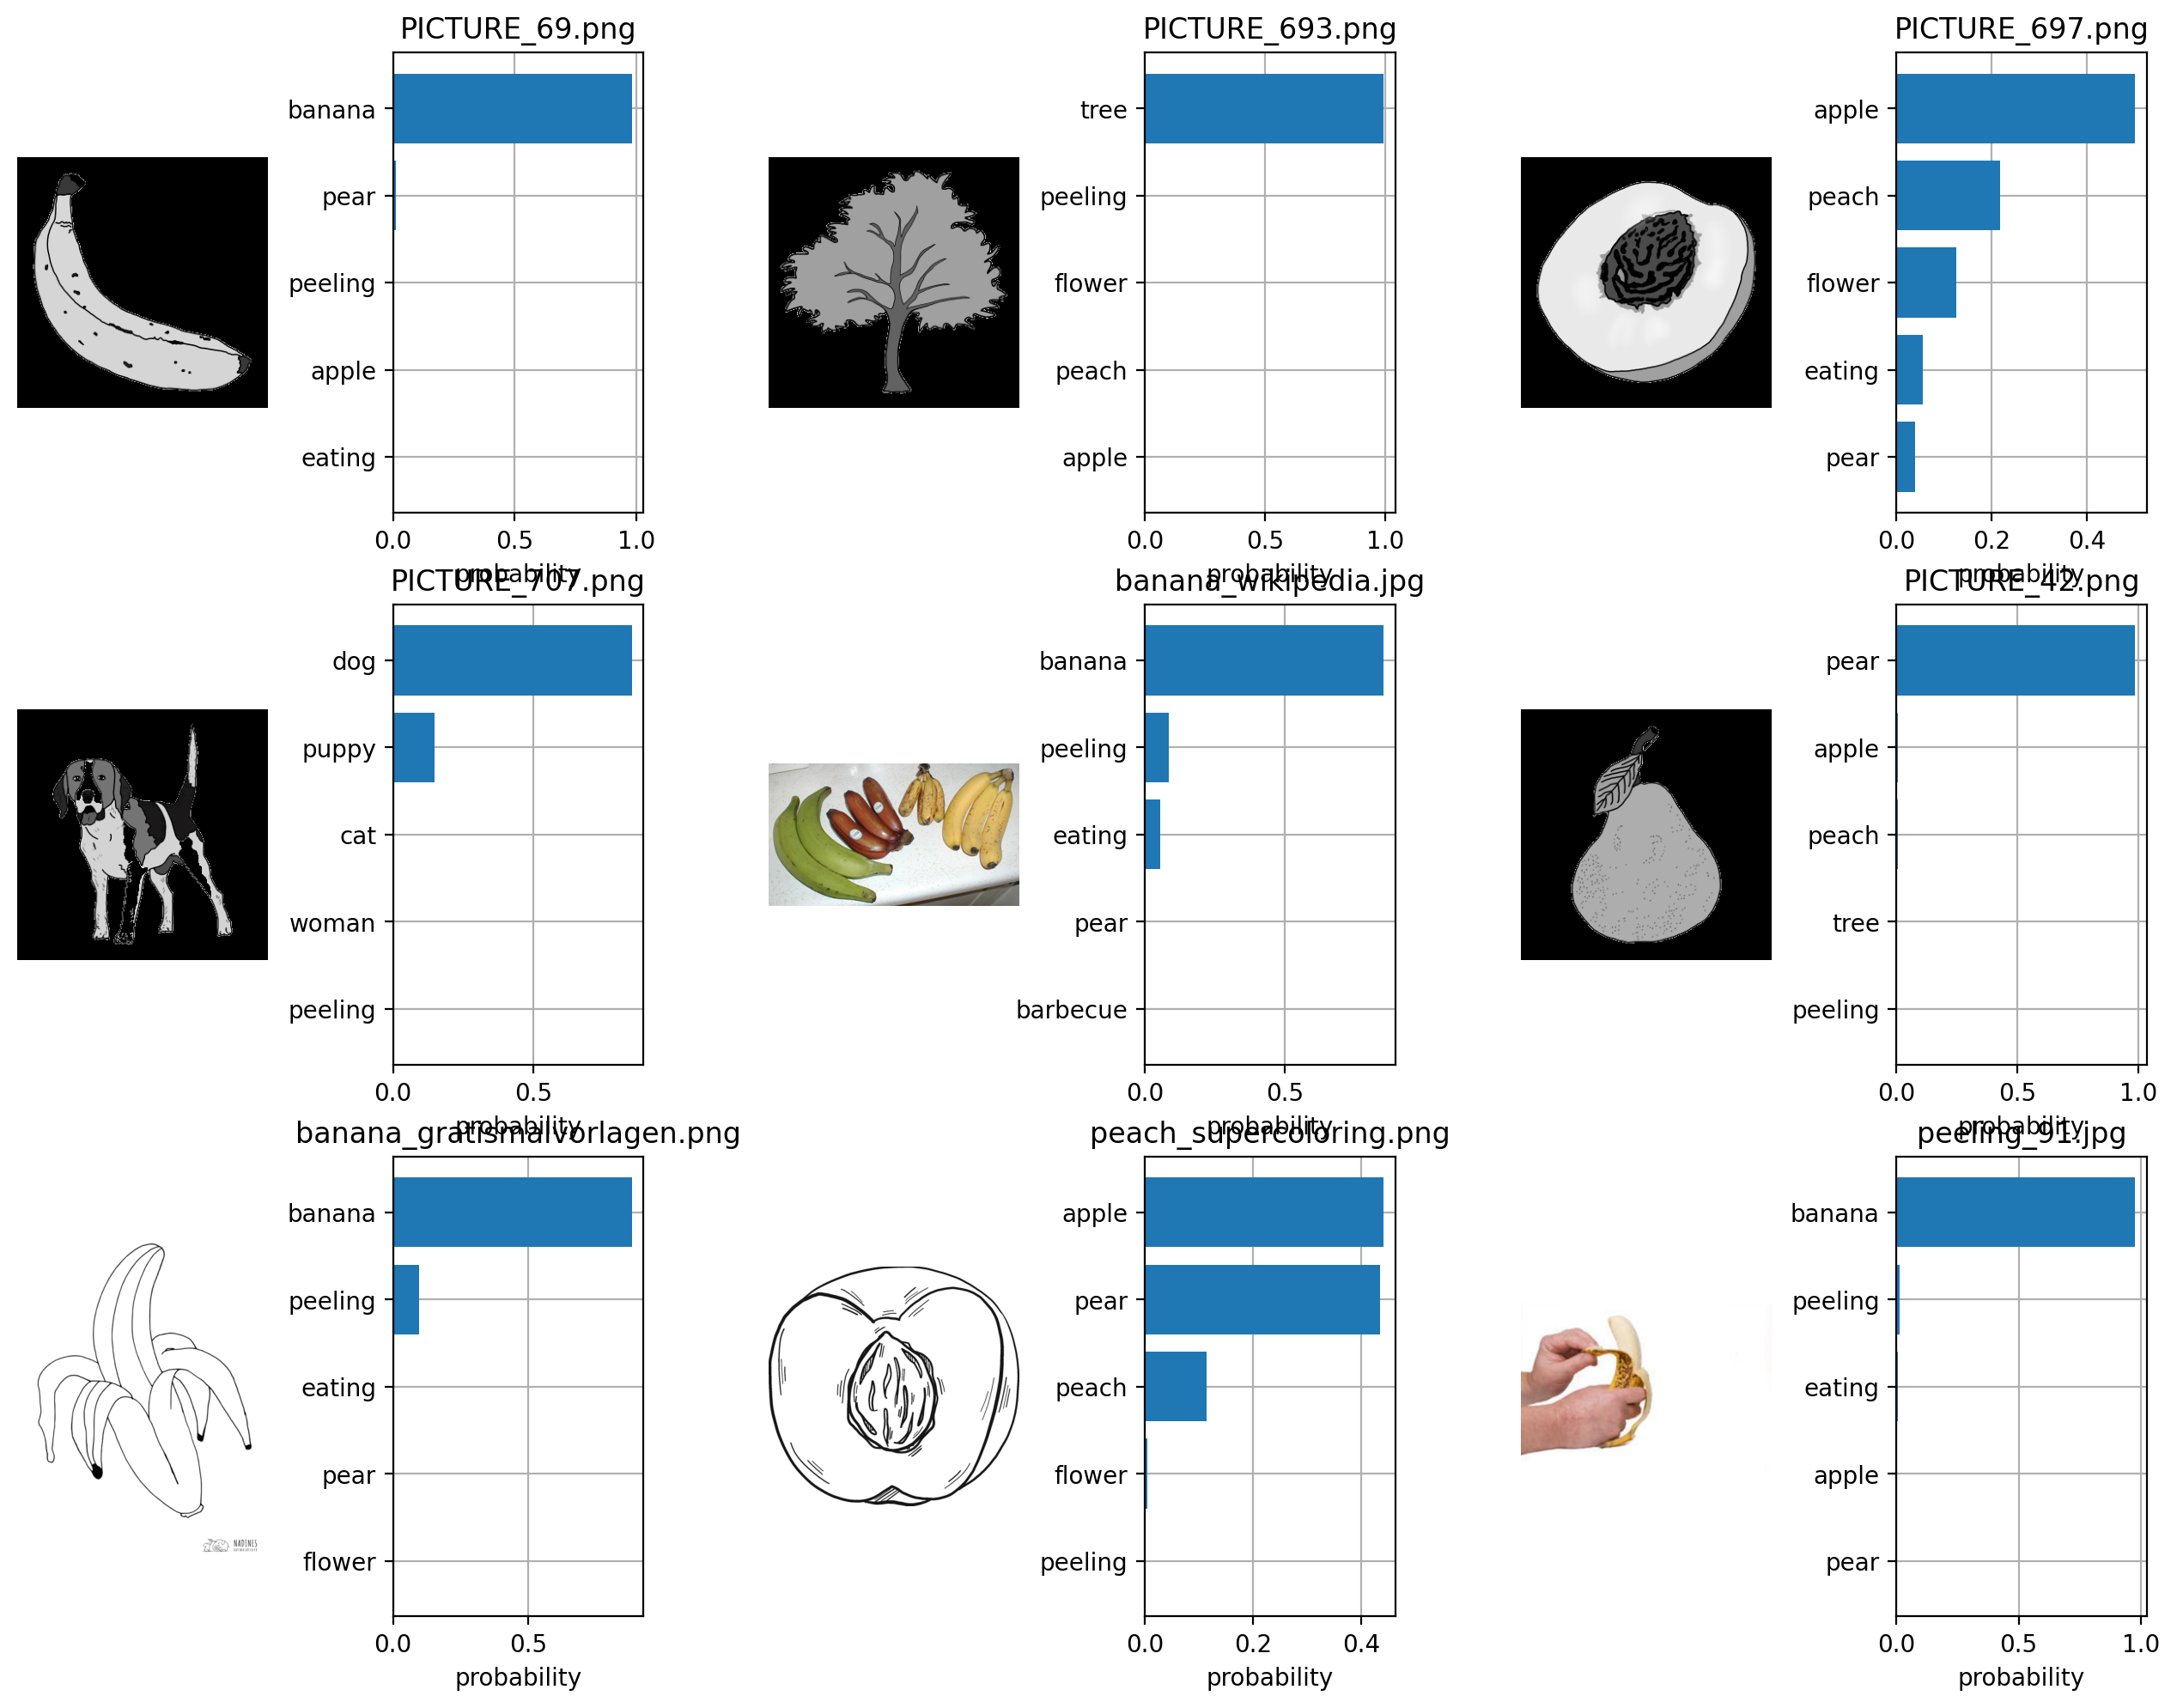

In [98]:
# Example
plot_predictions(images, imgnames,
                 top_probs, top_labels, target_classes)   

### Zero-shot Classification: Putting it all together

In [133]:
images = []
imgnames = []
list_target_inds = [] # we store the target labels' index of their position in the class vector (our_classes)
kPreds = 5
class2idx = {c:idx for (idx,c) in enumerate(target_classes)}

with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for (item_id, target) in coloured_objects_data.items():
        if item_id.endswith(".png") or item_id.endswith(".jpg"):
            image = Image.open(os.path.join(image_dir, item_id)).convert("RGB")
            imgnames.append(item_id)
            list_target_inds.append(class2idx[target])
            images.append(image)
                
    target_inds = torch.tensor(list_target_inds).cpu()
    # encode textual class representations
    zeroshot_text = [f"a rendering of a {label} ." for label in target_classes]
    # predict the class of each item 
    top_probs, top_labels = predict(images, zeroshot_text, target_classes, model, topk=kPreds)

    # measure accuracy
    acc1, acc5 = accuracy(top_probs, top_labels, target_inds, topk=(1,kPreds))

top1 = acc1*100
top5 = acc5*100 

print(f"Top-1 accuracy: {acc1:.2f}")
print(f"Top-5 accuracy: {acc5:.2f}")

Top-1 accuracy: 0.67
Top-5 accuracy: 1.00


### Exercise
Devise your own task of your interest. For example compute the similarity between descriptions and images of your choice, manipulating the descriptions minimally in the form of paraphrasing and observe the differences in the model output. Or predict shown actions in images. 